# Demographic Impact on Mental Health Responses 

## INTRODUCTION

Goal: to analyze how different demographic groups (e.g., age, gender, country) experience and report mental health conditions such as depression and anxiety in the technology industry. This includes exploring prevalence, potential risk factors, and how workplace environments influence mental well-being.

Are certain age groups more likely to report anxiety or depression?

Do responses differ significantly between men and women?

Is there a regional or national variation in responses?


This can provide insights into which groups might need targeted mental health interventions.

Importing libraries :

In [1]:
import sqlite3
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import geopandas as gpd
import statsmodels.stats.proportion as smp
from phik import phik_matrix

from MentalHealthCustomFunctionsDictionaries import (
    filter_unrealistic_ages,
    question_mapping,
    gender_mapping,
    country_mapping,
    condition_mapping,
    plot_age_boxplot,
    plot_geographic_distribution,
    plot_state_distribution,
    get_state_data,
    plot_age_distribution,
    plot_gender_distribution,
    countries_distribution_percentages,
    plot_cleaned_state_distribution_horizontal_bar_chart,
    plot_mental_health_conditions,
    plot_mental_health_conditions_with_CI,
    categorize_condition,
    plot_mental_health_conditions_by_gender_raw,
)

Defining the database :

In [2]:
db_path = "mental_health.sqlite"

Establishing a connection to a SQLite database and creating a cursor object to interact with it. The cursor is like a handle that you use to execute SQL queries and fetch results from the database :

In [3]:
conn = sqlite3.connect(db_path)
cursor = conn.cursor()

Using a context manager to automatically close the connection. When the code block within the with statement will be exited, the connection will be automatically closed, even if the errors occur :

In [4]:
with sqlite3.connect(db_path) as conn:
    cursor = conn.cursor()

## DATA CLEANING

Fetching all table names :

In [5]:
cursor.execute("SELECT name FROM sqlite_master WHERE type='table';")
tables = cursor.fetchall()
table_names = [table[0] for table in tables]
print("Tables in database:", table_names)

Tables in database: ['Answer', 'Question', 'Survey']


Previewing each table's schema (PRAGMA table_info (table_name) - retrieves metadata about a table, including information about its columns) :

In [6]:
for table in table_names:
    print(f"\nSchema of {table}:")
    cursor.execute(f"PRAGMA table_info({table});")
    schema = cursor.fetchall()
    for column in schema:
        print(column)


Schema of Answer:
(0, 'AnswerText', 'VARCHAR(10000)', 0, None, 0)
(1, 'SurveyID', 'INTEGER', 0, None, 0)
(2, 'UserID', 'INTEGER', 0, None, 0)
(3, 'QuestionID', 'INTEGER', 0, None, 0)

Schema of Question:
(0, 'questiontext', 'VARCHAR(1000)', 0, None, 0)
(1, 'questionid', 'INTEGER', 0, None, 0)

Schema of Survey:
(0, 'SurveyID', 'INTEGER', 1, None, 1)
(1, 'Description', 'VARCHAR(255)', 0, None, 0)


Reading the data from three different tables in a SQLite database and loading them into the pandas :

In [7]:
answer_df = pd.read_sql("SELECT * FROM Answer", conn)
question_df = pd.read_sql("SELECT * FROM Question", conn)
survey_df = pd.read_sql("SELECT * FROM Survey", conn)

Merging tables to create a full dataset. This combines related data, makes it easier to analyze and understand it :

In [8]:
merged_df = answer_df.merge(
    question_df, left_on="QuestionID", right_on="questionid", how="left"
).merge(survey_df, on="SurveyID", how="left")

Standardizing and grouping similar questions across survey years. This is a crucial step in data cleaning and preparation, especially when dealing with survey data where questions might be phrased differently but essentially ask the same thing. It also gives more data consistency and code readibility (using dictionary from a supportive file) :

In [9]:
merged_df["questiontext"] = merged_df["questiontext"].replace(question_mapping)

Dealing with missing data. Filling any missing values (NaN) in the AnswerText column of merged_df with the string "Not Provided" :

In [10]:
merged_df["AnswerText"] = merged_df["AnswerText"].fillna("Not Provided")

Standardizing gender responses. Code addresses potential inconsistencies in how people might input their gender, ensuring uniformity for analysis (using dictionary from a supportive file) :

In [11]:
merged_df.loc[merged_df["questiontext"] == "Gender", "AnswerText"] = (
    merged_df.loc[merged_df["questiontext"] == "Gender", "AnswerText"]
    .str.strip()
    .str.title()
)
merged_df.loc[merged_df["questiontext"] == "Gender", "AnswerText"] = merged_df.loc[
    merged_df["questiontext"] == "Gender", "AnswerText"
].replace(gender_mapping)

Converting age to numeric. This is a crucial step to ensure performing numerical operations on the age data.:

In [12]:
merged_df.loc[merged_df["questiontext"] == "Age", "AnswerText"] = pd.to_numeric(
    merged_df.loc[merged_df["questiontext"] == "Age", "AnswerText"], errors="coerce"
)

Taking a closer look at the age outliers with box plot (function from a supportive file): 

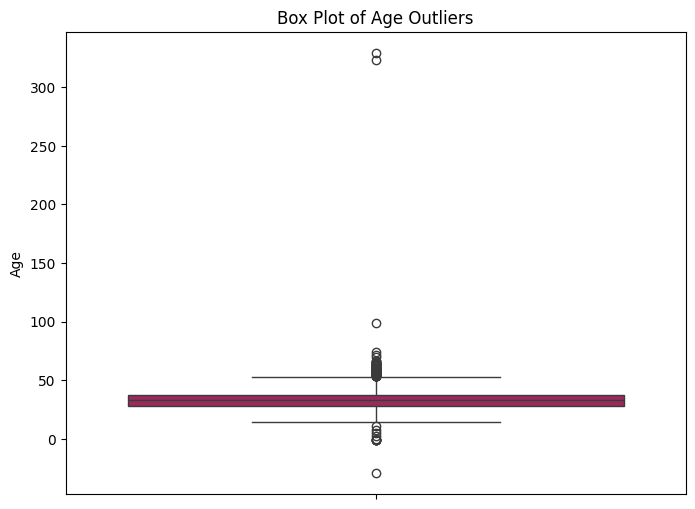

In [13]:
plot_age_boxplot(merged_df)

It seems that there's some unrealistic ages like the one's above 100 and below 0 we should remove them.

Converting 'AnswerText' related to age to a numeric (Without errors="coerce", pd.to_numeric() would raise a ValueError). The code snippet extracts the "AnswerText" values related to "Age", attempts to convert them to numbers, and replaces any non-convertible values with NaN.  The result is stored in temp_age_numeric :

In [14]:
temp_age_numeric = pd.to_numeric(
    merged_df.loc[merged_df["questiontext"] == "Age", "AnswerText"], errors="coerce"
)

Detecting and replacing outliers, ensuring negative ages and unrealistically old ages are handled. Using function filter_unrealistic_ages that filters out unlikely age values from a Pandas Series, replacing them with NaN :

In [15]:
temp_age_numeric_cleaned = filter_unrealistic_ages(
    temp_age_numeric, min_age=0, max_age=100
)
merged_df.loc[merged_df["questiontext"] == "Age", "AnswerText"] = (
    temp_age_numeric_cleaned.fillna("Not Provided")
)

Standardizing country names for better data consistency. As well there's countries with the same name like United States and United States of America, we have to take care of that using country_mapping dictionary and replace function :


In [16]:
# Standardize country names: strip spaces, title case
merged_df.loc[merged_df["questiontext"] == "Country", "AnswerText"] = (
    merged_df.loc[merged_df["questiontext"] == "Country", "AnswerText"]
    .str.strip()
    .str.title()
)

# Apply mapping to standardize country names
merged_df.loc[merged_df["questiontext"] == "Country", "AnswerText"] = merged_df.loc[
    merged_df["questiontext"] == "Country", "AnswerText"
].replace(country_mapping)

Isolating the age data, removing missing values :

In [17]:
age_series = merged_df.loc[merged_df["questiontext"] == "Age", "AnswerText"].dropna()

Age data processing and categorization :
1. Converts the age_series to numeric (errors="coerce" forces any non-numeric values to become NaN). Removes any NaN values that might have resulted from the previous conversion, ensuring only numbers should be staying.
2. Creating "Age group" column in the age_series after all cleaning and processing. Two lists with labels and bins are created as well. Bins defines age ranges groups.
3. Checking unique values.

In [18]:
age_series = pd.to_numeric(age_series, errors="coerce").dropna()

if not age_series.empty:
    merged_df.loc[merged_df["questiontext"] == "Age", "Age Group"] = pd.cut(
        age_series,
        bins=[0, 19, 29, 39, 49, 59, 100],
        labels=["<20", "20-29", "30-39", "40-49", "50-59", "60+"],
        right=False,
    )
else:
    merged_df.loc[merged_df["questiontext"] == "Age", "Age Group"] = "Not Provided"

print(age_series.unique())

[37. 44. 32. 31. 33. 35. 39. 42. 23. 29. 36. 27. 46. 41. 34. 30. 40. 38.
 50. 24. 18. 28. 26. 22. 19. 25. 45. 21. 43. 56. 60. 54. 55. 48. 20. 57.
 58. 47. 62. 51. 65. 49.  5. 53. 61.  8. 11. 72. 52. 17. 63. 99.  3. 66.
 59. 15. 74. 70. 64. 67.  0.]


Aggregating the merged_df by SurveyID and questiontext, keeping only the most frequent AnswerText for each combination. If multiple answers are equally frequent, it selects the first one encountered. Why do this? In surveys, respondents might provide multiple answers to a single question. This code helps consolidate those multiple answers into a single representative value (the mode) for each question within each survey. Also it's better for analysis cleaniness and visualizations. I will also check merged_df shape before and after aggregation to confirm it's effectiveness :

In [19]:
print(f"merged_df shape after group by: {merged_df.shape}")

merged_df = (
    merged_df.groupby(["SurveyID", "questiontext"])
    .agg(
        {"AnswerText": lambda x: x.mode()[0] if not x.mode().empty else "Not Provided"}
    )
    .reset_index()
)

print(f"merged_df shape after group by: {merged_df.shape}")

merged_df shape after group by: (236898, 8)
merged_df shape after group by: (314, 3)


Creating new DataFrame called expanded_df. It has a row for every combination of SurveyID and questiontext, even if there wasn't an answer for that combination in the original merged_df. It ensures completeness - in surveys, some respondents might not answer all questions. This code ensures that your DataFrame has a row for every possible combination of SurveyID and questiontext, making it easier to analyze and visualize patterns, even for unanswered questions.

In [20]:
full_survey_list = merged_df["SurveyID"].unique()
full_question_list = merged_df["questiontext"].unique()
full_index = pd.MultiIndex.from_product(
    [full_survey_list, full_question_list], names=["SurveyID", "questiontext"]
)
expanded_df = (
    merged_df.set_index(["SurveyID", "questiontext"]).reindex(full_index).reset_index()
)

Filling missing answers with "Not Asked" for surveys where the question was absent :

In [21]:
expanded_df["AnswerText"] = expanded_df["AnswerText"].fillna("Not Asked")

 Printing cleaned dataset :

In [22]:
print(expanded_df.head())

   SurveyID                                      questiontext  AnswerText
0      2014                                               Age        29.0
1      2014  Anonymity Protection for Mental Health Treatment  Don't know
2      2014                  Any additional notes or comments          -1
3      2014           Awareness of Mental Health Care Options          No
4      2014                                      Company Size        6-25


The data on states are not clean, I will have to custom get_state_data function to properly manage it : 

In [23]:
state_data = get_state_data(db_path)

print(state_data.head())

        state  respondent_count
0  California               382
1    Illinois               223
2  Washington               168
3    New York               146
4   Tennessee               121


##  Demographic Distribution

Visualizing results with a bar chart (custom function from a supportive file):

The bar chart categorizes respondents into six age groups:

<20 (Younger respondents)
20-29 (Early-career professionals or students)
30-39 (Mid-career professionals)
40-49 (Experienced professionals)
50-59 (Late-career professionals)
60+ (Retired or senior professionals)

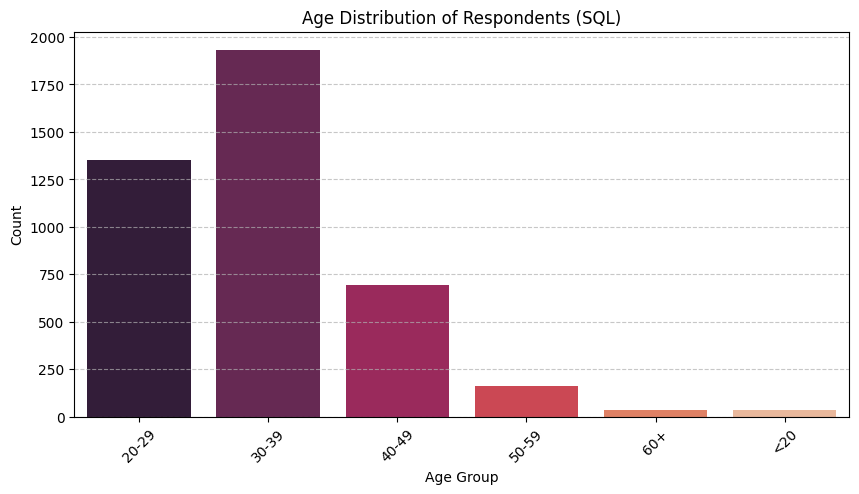

In [24]:
plot_age_distribution(db_path)

The 20-29 age group has the highest participation, likely representing early-career professionals and students who are more engaged in digital platforms and surveys.
The 30-39 age group also shows strong participation, reflecting mid-career individuals who may have a vested interest in workplace or mental health discussions.
Respondents above 50 years old are significantly fewer, which could indicate lower survey reach among older demographics or less willingness to participate.

This distribution suggests that younger individuals, particularly those in their 20s and 30s, are more engaged with the survey topic. If the survey relates to workplace culture, mental health, or technology, this age skew could reflect the greater awareness and discussions around these issues among younger professionals.

SQL Query for gender breakdown:

Visualizing the data :

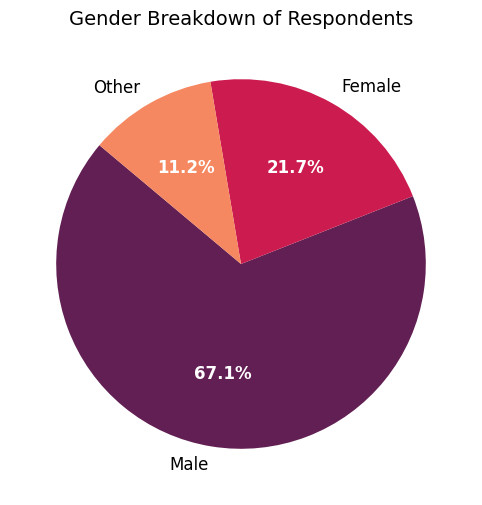

In [25]:
plot_gender_distribution(db_path)

67.1% of respondents are male, with females (21.7%) and other gender identities (11.2%) being clear minorities. This aligns with broader industry trends, where men dominate tech-related fields. Factors such as workplace culture, hiring biases, and gender disparities in STEM education may contribute to this imbalance.

What is the geographic distribution of respondents?

The geographic distribution of survey respondents provides a view of regional engagement, but it may also reflect external factors influencing participation.

Key Considerations:

Tech Industry Presence: Higher response rates in certain regions may correlate with tech sector development rather than overall engagement. Areas with a strong technology workforce likely have higher survey visibility.

Survey Outreach Bias: Some regions may show higher participation due to targeted outreach efforts. If the survey was shared more actively in specific countries or states, the data might reflect where respondents were most likely to be reached rather than genuine interest differences.

Language & Accessibility: Lower participation in some regions could be due to language barriers or lack of familiarity with the survey platform, affecting overall representation.

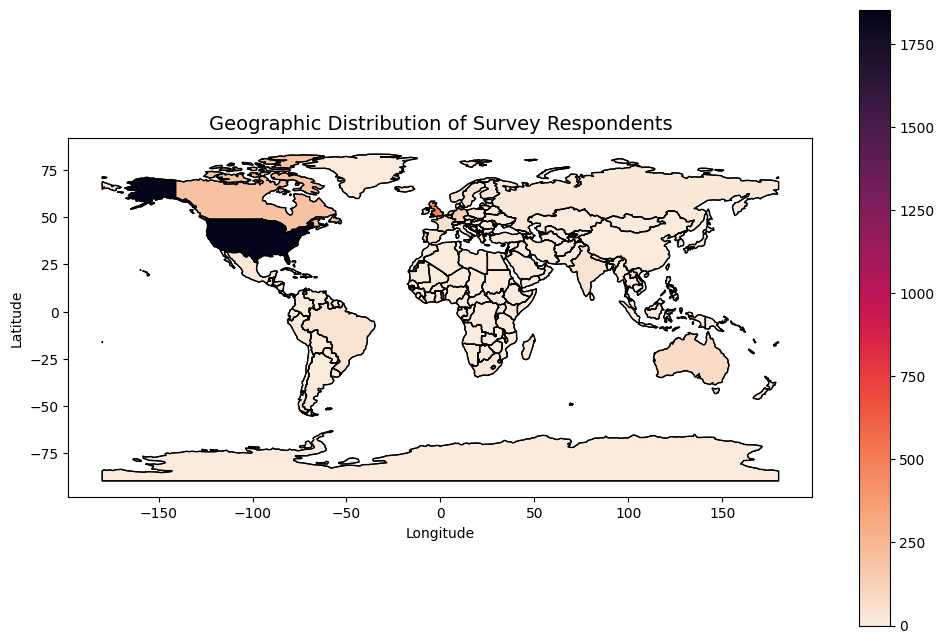

In [26]:
shapefile_path = "ne_110m_admin_0_countries/ne_110m_admin_0_countries.shp"

plot_geographic_distribution(db_path, shapefile_path)

World map graph shows that the survey participants were mainly from US, with small of participants being from UK, Germany, Australia and Canada as well.

In [27]:
# Get cleaned country distribution from SQL
cleaned_country_df = countries_distribution_percentages(db_path)

# Display cleaned country data
print(cleaned_country_df)

           Country  Percentage
0    United States   61.735420
1   United Kingdom   11.427217
2           Canada    4.717876
3          Germany    3.224277
4      Netherlands    2.323376
..             ...         ...
75        Ethiopia    0.023708
76         Ecuador    0.023708
77          Brunei    0.023708
78         Belarus    0.023708
79    Bahamas, The    0.023708

[80 rows x 2 columns]


United States (61.73%) - The overwhelming majority of responses came from the U.S., likely due to survey reach, language accessibility, and industry concentration.

United Kingdom (11.43%) - A significant number of responses suggest strong awareness or outreach efforts in English-speaking countries.

Canada (4.72%) & Germany (3.22%) - These countries show moderate participation, possibly reflecting their tech industry engagement.

Low-Participation Countries (≤0.02%) - Countries like Ethiopia, Ecuador, Brunei, Belarus, and The Bahamas have minimal engagement, possibly due to limited survey outreach or tech sector presence in these regions.

Let's take a closer look at US and it's states geographic distribution of survey respondents :

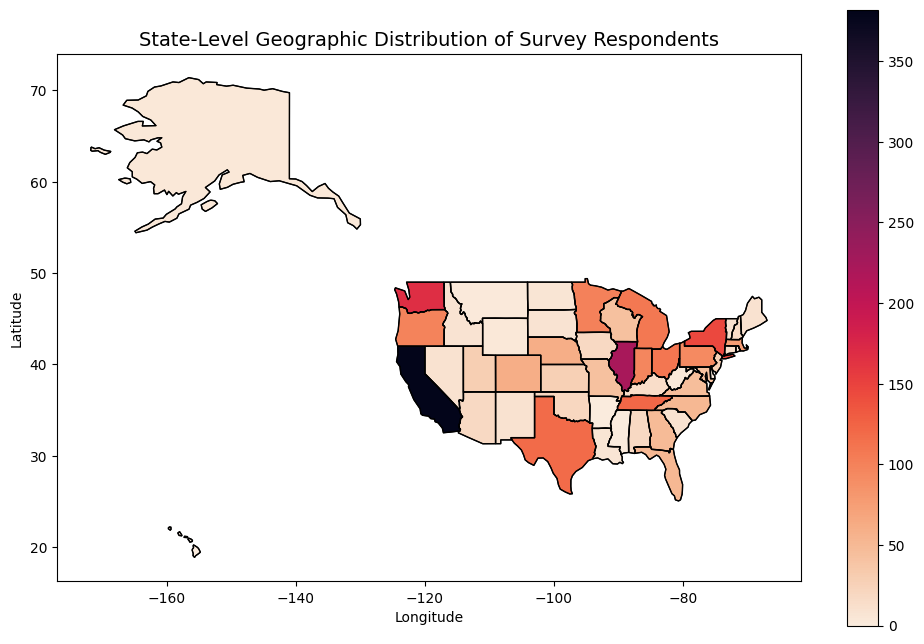

In [28]:
shapefile_path = "ne_110m_admin_1_states_provinces/ne_110m_admin_1_states_provinces.shp"

plot_state_distribution(db_path, shapefile_path)

State map is dominated by California, followed by Ilinious and Washington states. Not surprising since majority of technology companies are based in California.

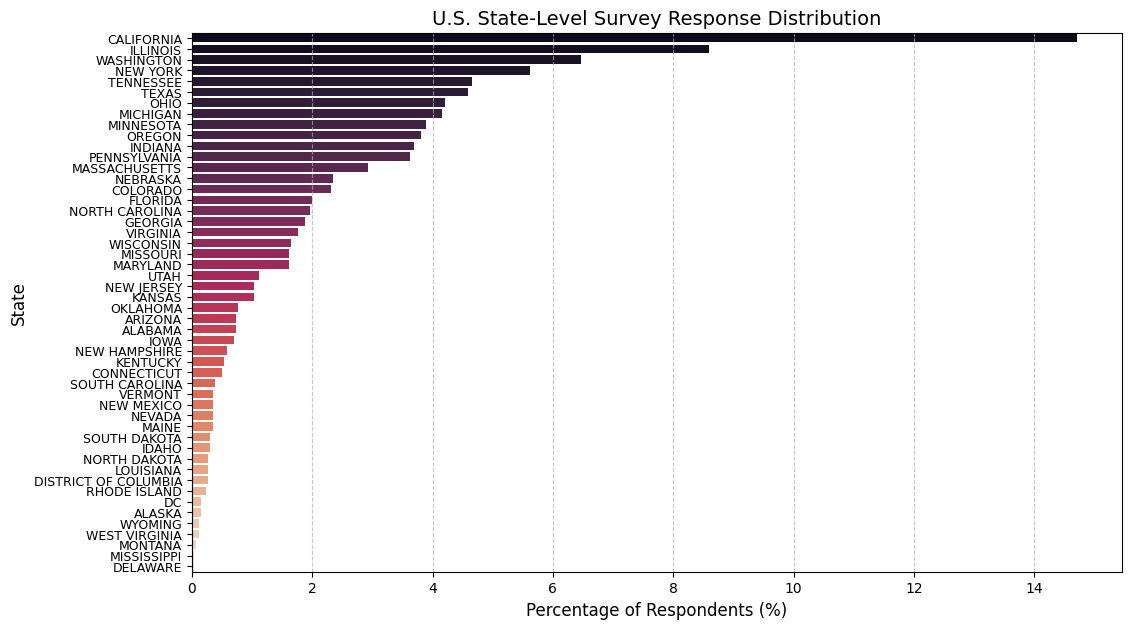

In [29]:
cleaned_state_df = plot_cleaned_state_distribution_horizontal_bar_chart(db_path)

Key findings :

•California leads the responses, with the highest percentage of survey participants. This aligns with its position as a major tech and corporate hub, where workplace mental health discussions are more prevalent.

•Illinois, Washington, and New York also show strong participation, reflecting high concentrations of professionals in urban areas and industries where mental health awareness is growing.

•Texas and Florida, despite having large populations, show relatively lower response rates, suggesting possible regional differences in survey outreach or awareness.

•Lower participation states (e.g., Montana, Mississippi, Delaware) make up a very small percentage of responses, likely due to lower survey visibility in these regions or differences in workplace culture.

Additional insights :

1. Higher participation in states with strong tech, finance, and corporate presence suggests that workplace mental health awareness may be more developed in these regions.

2. Lower engagement in some states could indicate gaps in awareness, industry representation, or outreach strategies.

3. Future surveys should consider targeted outreach in lower-participation states to improve geographic representation.

## Overview on Main Mental Conditions and Their Prevelance

Understanding the prevalence of diagnosed mental health conditions helps identify the most common disorders among respondents. This analysis focuses on self-reported mental health diagnoses based on Question 115, where participants specify their diagnosed conditions.

The bar chart below shows the prevalence of diagnosed mental health conditions, categorized into major disorder types:

Anxiety Disorders - Includes Generalized Anxiety, Social Anxiety, Phobias

Depression - Includes Mood Disorders & Clinical Depression

Bipolar Disorder - Includes Bipolar I & II

OCD (Obsessive-Compulsive Disorder)

PTSD (Post-Traumatic Stress Disorder)

Eating Disorders - Includes Anorexia & Bulimia

Stress Disorders - Includes Stress Response Syndromes

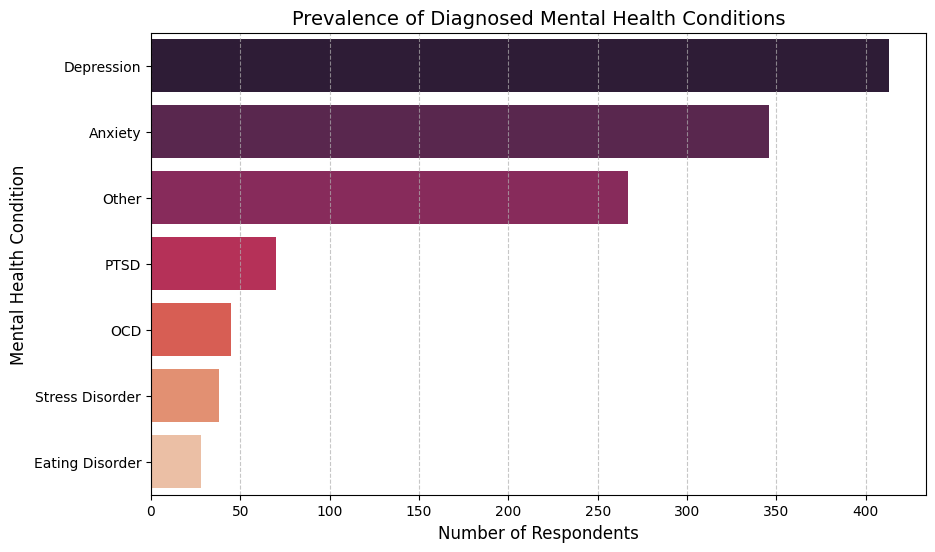

In [30]:
mental_health_summary_df = plot_mental_health_conditions(db_path)

Key Findings :

Conditions like Anxiety and Depression are the most frequently reported mental health disorders.

Bipolar Disorder, OCD, PTSD, and Eating Disorders are also reported but at a lower frequency.

Some responses were unstructured or unclear and categorized under "Other" conditions.

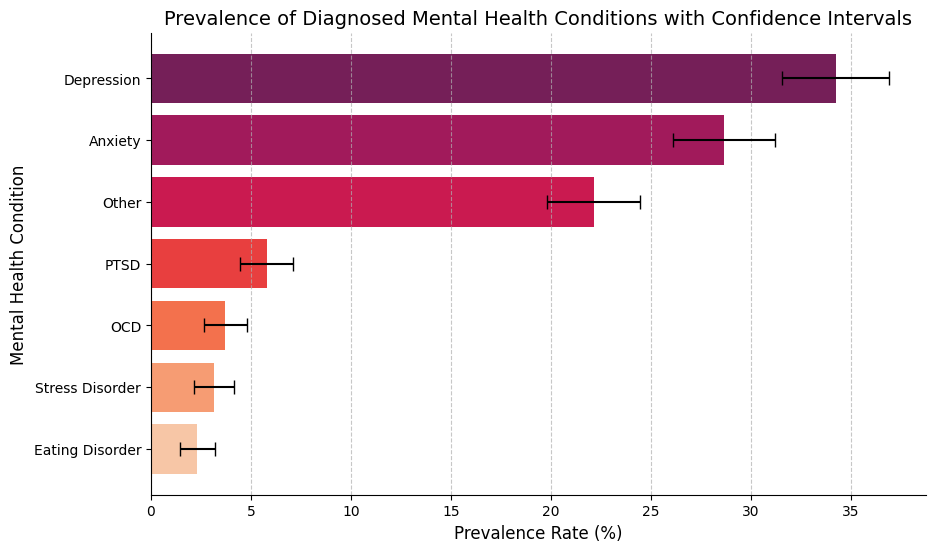

In [31]:
mental_health_summary_CI_df = plot_mental_health_conditions_with_CI(
    db_path=db_path,
    condition_mapping=condition_mapping,
)

The most frequently reported mental health condition among respondents is Depression, followed by Anxiety Disorders and PTSD.

Depression has the highest prevalence, suggesting that mood disorders are a major concern among respondents.

Confidence intervals (error bars) indicate the uncertainty in prevalence estimates. Wider intervals suggest greater variability in responses, while narrower intervals indicate more certainty.

Bipolar Disorder, OCD, and Eating Disorders have lower prevalence but remain critical areas of concern.

Confidence intervals provide an estimate of the true prevalence within the broader population.

If a condition has a wide confidence interval, it suggests higher uncertainty in the estimated rate, possibly due to fewer responses or varying reporting patterns.

If a confidence interval is narrow, it indicates more reliable data with a higher degree of certainty.

## Deeper Analysis of Mental Conditions and Demografic Factors

Which demografic factors can influence mental conditions?

In [32]:
print("Merged_df columns:", merged_df.columns)

Merged_df columns: Index(['SurveyID', 'questiontext', 'AnswerText'], dtype='object')


merged_df shape before filtering: (314, 3)
mh_df shape after filtering by QuestionID 115: (3, 3)
gender_df shape after filtering ('What is your gender?'): (5, 3)
merged_conditions shape after merge: (3, 5)
Gender
Male    int64
dtype: object
Gender    Male
Category      
Other        1


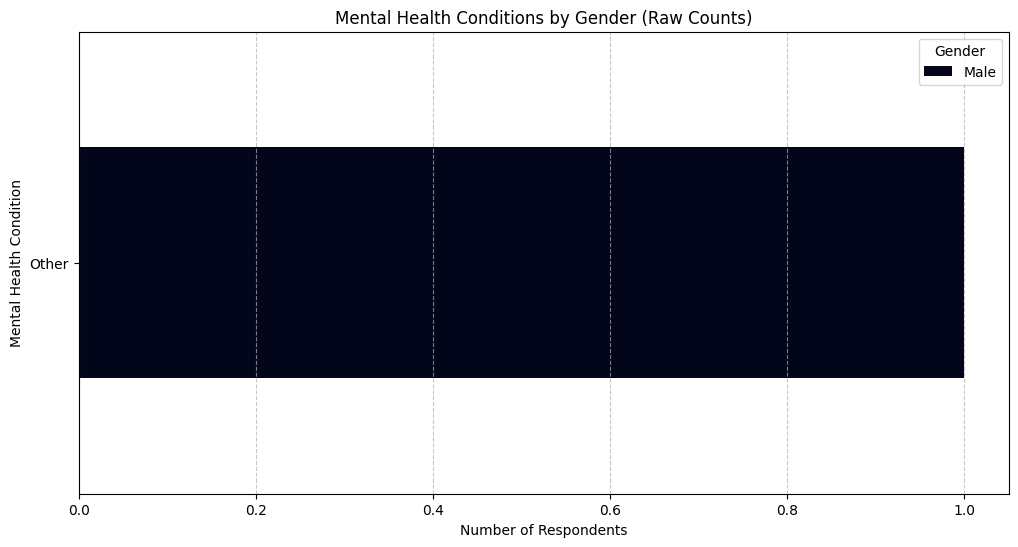

Gender    Male
Category      
Other        1


In [33]:
# Define the Question ID for mental health conditions and gender
condition_question_id = 115  # ✅ This is the ID for diagnosed mental health conditions
gender_question_text = (
    "What is your gender?"  # ✅ Ensure this matches exactly in merged_df
)

# Define the condition mapping
condition_mapping = {
    "Anxiety": ["anxiety disorder", "generalized anxiety", "social anxiety", "phobia"],
    "Depression": ["mood disorder", "depression"],
    "Bipolar Disorder": ["bipolar disorder"],
    "OCD": ["obsessive-compulsive disorder", "ocd"],
    "PTSD": ["post-traumatic stress disorder", "ptsd"],
    "Eating Disorder": ["eating disorder", "anorexia", "bulimia"],
    "Stress Disorder": ["stress response syndromes"],
}

# Call function to generate raw count graph
gender_condition_raw_df = plot_mental_health_conditions_by_gender_raw(
    merged_df=merged_df, condition_mapping=condition_mapping
)

# Print DataFrame results
print(gender_condition_raw_df)